In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Yeast gene name mapping
yeast_name_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

### Fig. 3A: Heatmap of the influence of yeast TF binding signals along regulatory DNA.
- Each pixel is the mean signed SHAP value over all target genes that were bound by the perturbed TFs.

In [3]:
cc_dir = '../OUTPUT/Yeast_cc_zev/all_feats/xgb/'
chipexo_dir = '../OUTPUT/Yeast_chipexo_zev/all_feats/xgb/'
tf_names = np.union1d(
    np.loadtxt('../RESOURCES/Yeast_CallingCards_TFs.txt', dtype=str),
    np.loadtxt('../RESOURCES/Yeast_ChIPexo_TFs.txt', dtype=str))

cc_sig_dir = '../RESOURCES/Yeast_CallingCards/tss1000to500b_sig'

resp_df = pd.read_csv('../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv', index_col='GeneName')
tfb_params = ('tf_binding', 1000, 100)

tfb_df_list = []

for tf_name in tf_names:
    try:
        tf_dir, is_cc, acc = get_best_yeast_model((cc_dir, chipexo_dir), tf_name)
        print('... working on', tf_dir)

        bound_targets = get_callingcards_bound_targets(cc_sig_dir, tf_name, resp_df.index) if is_cc else None
        tfb_df = calculate_tf_binding_shap(resp_df, tf_dir, tf_name, bound_targets, tfb_params)
        tfb_df['tf'] = yeast_name_dict[tf_name] if tf_name in yeast_name_dict else tf_name
        tfb_df['acc'] = acc
        tfb_df['assay'] = 'Calling cards' if is_cc else 'ChIP-exo'
        tfb_df_list.append(tfb_df)
        
    except:
        print('TF {} not available in Calling Cards or ChIP-exo'.format(tf_name))

tfb_df = pd.concat(tfb_df_list)

... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YAL051W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YBL103C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YBR239C
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YDR034C
TF YDR123C not available in Calling Cards or ChIP-exo
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YEL009C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YGL162W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YHR178W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YIL036W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YJL056C
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YJL089W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YJR060W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YKL038W
... working on ../OUTPUT/Yeast_chipexo_zev/all_feats/xgb//YLR256W
... working on ../OUTPUT/Yeast_cc_zev/all_feats/xgb//YLR403W
... working on ../OUTPUT/Yeast_cc_zev/all_feats

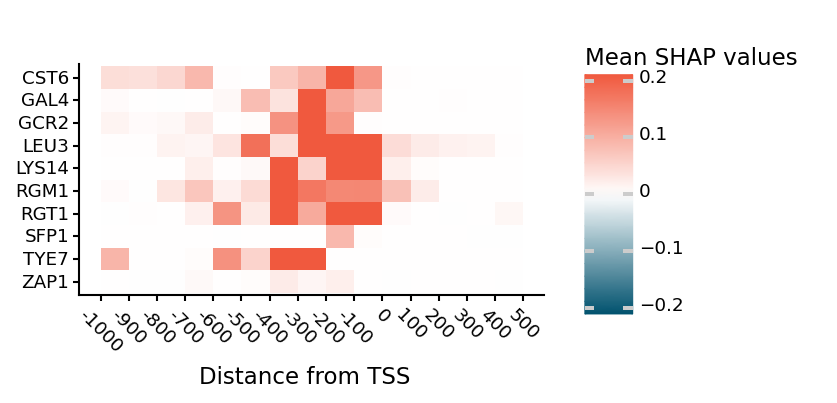

<ggplot: (-9223372029823130922)>

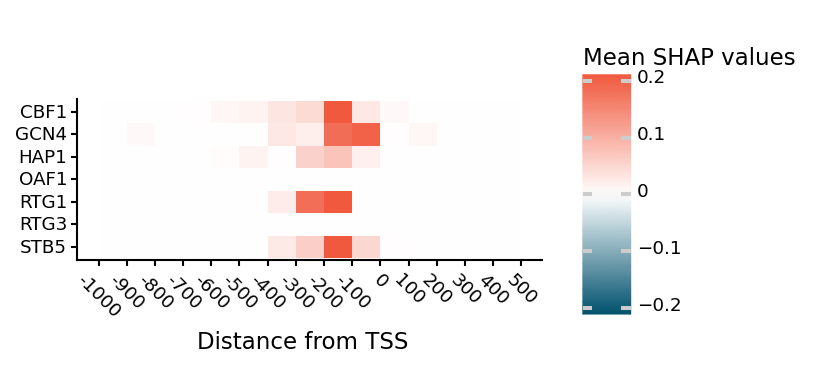

<ggplot: (-9223372029846227687)>

In [4]:
tfb_stats = tfb_df[
    (tfb_df['acc'] > 0.1) & (tfb_df['is_bound'] == 'Bound')].groupby(
    ['tf', 'assay', 'coord'])['shap'].mean().reset_index()
tfb_stats['coord'] = tfb_stats['coord'].astype(float)
tfb_stats['tf'] = pd.Categorical(
    tfb_stats['tf'], ordered=True, categories=sorted(tfb_stats['tf'].unique())[::-1])

ax = (
    ggplot(
        tfb_stats[tfb_stats['assay'] == 'Calling cards'], 
        aes(x='coord', y='tf', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['orange']], values=[0, 1/2, 1], limits=[-0.2, 0.2],
        name='Mean SHAP values')
    + scale_x_continuous(breaks=range(-1050, 451, 100), labels=range(-1000, 501, 100))
    + labs(x='Distance from TSS', y=None)
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'),
        axis_ticks_minor_x=element_blank())
)
display(ax)

ax = (
    ggplot(
        tfb_stats[tfb_stats['assay'] == 'ChIP-exo'], 
        aes(x='coord', y='tf', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['orange']], values=[0, 1/2, 1], limits=[-0.2, 0.2],
        name='Mean SHAP values')
    + scale_x_continuous(breaks=range(-1050, 451, 100), labels=range(-1000, 501, 100))
    + labs(x='Distance from TSS', y=None)
    + theme_classic()
    + theme(
        figure_size=(4, 1.4), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'),
        axis_ticks_minor_x=element_blank())
)
display(ax)

### Fig. 3B: Comparison of two upstream bins ([-500, -400] and [-200, -100]) of yeast TF Leu3

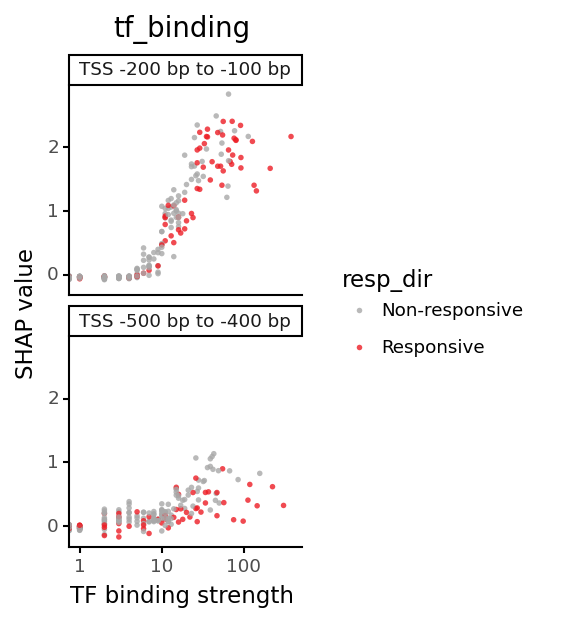

<ggplot: (7031159339)>

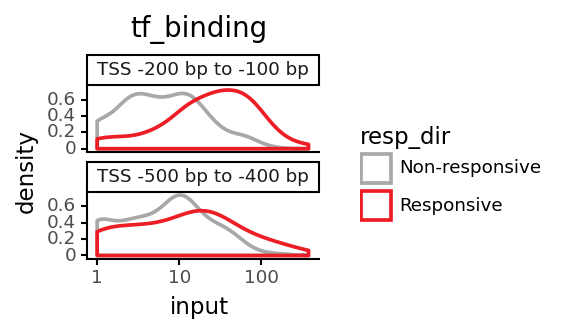

<ggplot: (7008558968)>

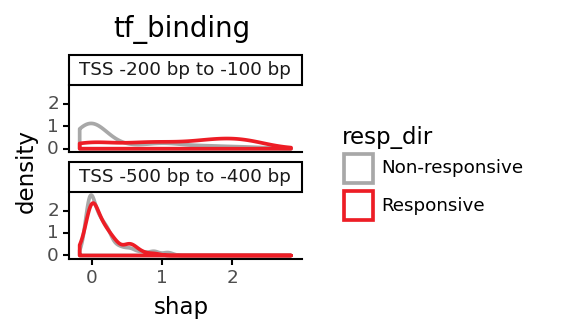

<ggplot: (-9223372029839415920)>

In [5]:
tf_com_name = 'LEU3'
coords = [-500, -200]

plot_df = tfb_df[
    (tfb_df['is_bound'] == 'Bound') & \
    (tfb_df['tf'] == tf_com_name) & \
    (tfb_df['coord'].isin(coords))]
plot_df['coord_bin'] = ['TSS {:d} bp to {:d} bp'.format(int(x), int(x) + 100) for x in plot_df['coord']]

## TFB vs SHAP
ax = (
    ggplot(plot_df, aes(x='input', y='shap', fill='resp_dir'))
    + geom_point(alpha=.8, stroke=0)
    + scale_fill_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1)
    + labs(x='TF binding strength', y='SHAP value')
    + scale_x_continuous(trans='log10')
    + ggtitle(tfb_params[0])
    + theme_classic()
    + theme(figure_size=(2, 4), dpi=150)
)
display(ax)

## Input TFB distribution
ax = (
    ggplot(plot_df, aes(x='input', color='resp_dir'))
    + geom_density(size=1)
    + scale_color_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1)
    + scale_x_continuous(trans='log10')
    + ggtitle(tfb_params[0])
    + theme_classic()
    + theme(figure_size=(2, 1.5), dpi=150)
)
display(ax)

## SHAP distribution
ax = (
    ggplot(plot_df, aes(x='shap', color='resp_dir'))
    + geom_density(size=1)
    + scale_color_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1)
    + ggtitle(tfb_params[0])
    + theme_classic()
    + theme(figure_size=(2, 1.5), dpi=150)
)
display(ax)

### Fig. 3C: Comparison of feature influences on responsive and unresponsive targets that were bound by Leu3
- P < 0.05 (*), p < 0.01 (**), P < 0.001(***), Wilcoxon rank-sum test. 
- The significant differences all show that responsive genes are bound more strongly than unresponsive genes. 

In [6]:
resp_val_df = pd.DataFrame()
resp_cmp_df = pd.DataFrame()

tfb_subdf = tfb_df[
    (tfb_df['tf'] == tf_com_name) & \
    (tfb_df['assay'] == 'Calling cards') & \
    (tfb_df['is_bound'] == 'Bound') & \
    (tfb_df['acc'] > 0.1)]

for coord, subdf in tfb_subdf.groupby('coord'):
    r_vals = subdf.loc[subdf['resp_dir'] == 'Responsive', 'shap'].values
    nr_vals = subdf.loc[subdf['resp_dir'] == 'Non-responsive', 'shap'].values
    try:
        stat, p = ss.mannwhitneyu(r_vals, nr_vals)
    except:
        p = 1
        
    resp_cmp_df = resp_cmp_df.append(pd.Series({
        'coord': int(coord), 'p': p, 'r>nr': np.mean(r_vals) > np.mean(nr_vals)
        }), ignore_index=True) 
    resp_val_df = resp_val_df.append(pd.DataFrame({
        'coord': [int(coord)] * len(r_vals), 'type': ['Bound & Responsive'] * len(r_vals), 'shap': r_vals
        }), ignore_index=True) 
    resp_val_df = resp_val_df.append(pd.DataFrame({
        'coord': [int(coord)] * len(nr_vals), 'type': ['Bound & Unresponsive'] * len(nr_vals), 'shap': nr_vals
        }), ignore_index=True)
    
resp_val_df['coord'] = pd.Categorical(
    resp_val_df['coord'], ordered=True,
    categories=sorted(resp_val_df['coord'].unique()))

coord: -600, P-value: 0.027914
coord: -400, P-value: 0.025549
coord: -300, P-value: 0.000143
coord: -200, P-value: 0.000000
coord: -100, P-value: 0.000000


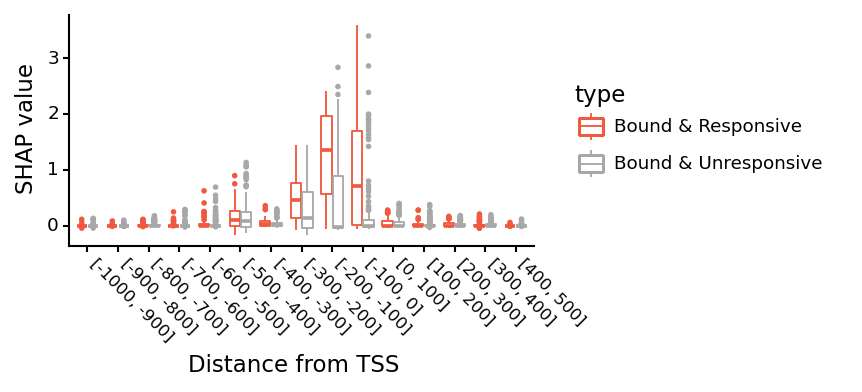

<ggplot: (7008462207)>

In [7]:
## Print stats
for _, row in resp_cmp_df.iterrows():
    if (row['p'] < 0.05) and (row['r>nr']):
        print('coord: {:d}, P-value: {:.6f}'.format(int(row['coord']), row['p']))

ax = (
    ggplot(resp_val_df, aes(x='coord', y='shap', color='type'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['orange'], COLORS['grey']])
    + scale_x_discrete(
        breaks=range(-1000, 500, 100), 
        labels=['[{:d}, {:d}]'.format(int(x), int(x) + 100) for x in range(-1000, 500, 100)])
    + labs(x='Distance from TSS', y='SHAP value')
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45, hjust=0, size=8),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 3D: Number of 100 bp promoter bins in which the bound and responsive genes have significantly higher SHAP values for TF binding (P < 0.05) than the bound but non-responsive genes
- Blue bars: calling cards; Green bars: ChIP-exo

In [8]:
resp_cmp_df = pd.DataFrame()

for (tf1, assay), subdf1 in tfb_df[
    (tfb_df['is_bound'] == 'Bound') & \
    (tfb_df['acc'] > 0.1)].groupby(['tf', 'assay']):
    
    tmp_df = pd.DataFrame()
    for coord, subdf2 in subdf1.groupby('coord'):
        r_vals = subdf2.loc[subdf2['resp_dir'] == 'Responsive', 'shap'].values
        nr_vals = subdf2.loc[subdf2['resp_dir'] == 'Non-responsive', 'shap'].values
        try:
            stat, p = ss.mannwhitneyu(r_vals, nr_vals)
        except:
            p = 1
        tmp_df = tmp_df.append(pd.Series({
            'coord': coord, 'p': p, 'r>nr': np.mean(r_vals) > np.mean(nr_vals)
            }), ignore_index=True) 
        
    tmp_df['adj_p'] = multipletests(tmp_df['p'], alpha=0.05, method='hs')[1]
    tmp_df['tf'] = tf1
    tmp_df['assay'] = assay
    resp_cmp_df = resp_cmp_df.append(tmp_df, ignore_index=True)

## Summary stats
resp_cmp_df['p_score'] = -np.log10(resp_cmp_df['p'])
resp_cmp_df.loc[(resp_cmp_df['p'] >= 0.05) | (resp_cmp_df['r>nr'] == False), 'p_score'] = 0
resp_cmp_df['is_sig'] = resp_cmp_df['p_score'] > 0

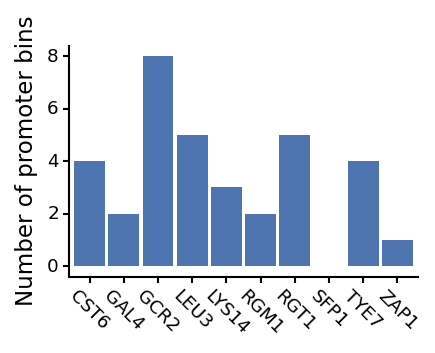

<ggplot: (-9223372029839236166)>

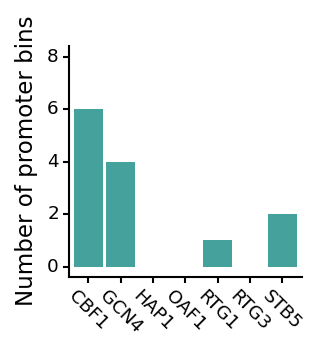

<ggplot: (-9223372029839405024)>

In [9]:
resp_cnt_df = resp_cmp_df.groupby(['tf', 'assay'])['is_sig'].sum().reset_index()
resp_cnt_df = resp_cnt_df.dropna()

resp_cnt_df['tf'] = pd.Categorical(
    resp_cnt_df['tf'], ordered=True, categories=sorted(resp_cnt_df['tf']))

ax = (
    ggplot(
        resp_cnt_df[resp_cnt_df['assay'] == 'Calling cards'], 
        aes(x='tf', y='is_sig'))
    + geom_bar(stat='identity', fill='#22529b', alpha=.8)
    + labs(y='Number of promoter bins', x=None)
    + ylim(0, 8)
    + theme_classic()
    + theme(
        figure_size=(3, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax = (
    ggplot(
        resp_cnt_df[resp_cnt_df['assay'] == 'ChIP-exo'], 
        aes(x='tf', y='is_sig'))
    + geom_bar(stat='identity', fill='#158a84', alpha=.8)
    + labs(y='Number of promoter bins', x=None)
    + ylim(0, 8)
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)